# <center>NEU AI Skunkworks

<img src="Images/Rikskunk2_Trans.png" width="300"/>


What is NEU AI Skunkworks:

Northeastern AI Skunkworks is a group of data enthusiasts who research and explore technology related Artificial Intelligence, Machine Learning primarily for innovation and learning.
What we do?

Dedicated to: 

Enlighten & enhance the interests for data enthusiasts by conducting open-mic, mentorship, workshops, seminars, hack-a-thons, and events that assist enthusiasts exploring the cutting edges AI technology.

Number we should know about NEU AI Skunkworks, since Feb.2019:

    • 380 members, increasing still…
    • 7 practical workshops held, get 300+ members involved in. 
    • 3 projects incubated by AI Skunkworks have been selected in research innovation scholarship entrepreneurship for further rewarding, and 6 projects are being incubated now.

Where is our future?

    • Strive to be the most solid and strong bridge to connect the campus data enthusiasts and cutting edges AI.
    • Incubate innovative projects to solve real problems for world and human.
    • Share, contribute all the time.

GitHub : https://github.com/skunkworksneu

Email ID: skunkworksneu@gmail.com

LinkedIn : http://linkedin.com/company/skunkworksneu

# Setting up H2O and loading datasets--Prabhu

## Predicting Good Amazon Reviews

For this demo, we will be using the [Amazon Fine Food Reviews Data](https://www.kaggle.com/snap/amazon-fine-food-reviews).  The Amazon Fine Food Reviews dataset consists of 568,454 food reviews Amazon users left up to October 2012.


## Import Data

We will begin by importing our review data into our H2O cluster. 

In [5]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [6]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

4


We initialize H2O for our working

In [7]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 mins 07 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,1 month and 18 days
H2O cluster name:,H2O_from_python_bear_ss5vss
H2O cluster total nodes:,1
H2O cluster free memory:,3.546 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


We load the data to the H2O local server to start operating with that

In [8]:
data_path = "data/AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


shape gives the row, column specification

In [9]:
reviews.shape

(55554, 10)

head by default gives the first 5 rows of the dataset

In [10]:
reviews.head()

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!"
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much direction. In comparison, the

In [11]:
reviews.describe()

Rows:55554
Cols:10




,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
type,enum,enum,enum,int,int,int,enum,int,int,string
mins,,,,1.0,0.0,3.0,,0.0,944438400.0,NaN
mean,,,,4.185675198905568,2.2578032184901184,284454.8548979371,,1.7664614609209053,1296260730.3596506,NaN
maxs,,,,5.0,878.0,568436.0,,866.0,1351209600.0,NaN
sigma,,,,1.3077531708482195,9.262838990830508,164193.9190660871,,8.638742394580309,47990174.93641191,NaN
zeros,,,,0,26415,0,,29722,0,0
missing,0,0,0,0,0,0,0,0,0,0
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1.0,2.0,41471.0,Evan Eberhardt,2.0,1348358400.0,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3.0,0.0,28582.0,coleridge,0.0,1323907200.0,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5.0,0.0,389965.0,Lindsay S. Bradford,0.0,1310601600.0,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


We create a new columns to carry our classification model which is explained in the later stage.

The new column getting generated by us is `PositiveReview` which is created on a logic by seperating the rows having the ratings greater or less than the mean = which is 4.2 in out case. We can see this under the `.describe`

In [12]:
#' Add Target Column: "PositiveReview"
# Note mean score around 4.2
reviews["PositiveReview"] = (reviews["Score"] >= 4.2).ifelse("1", "0")

In [13]:
reviews.head()

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats.",1
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.,1
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!",1
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much di

In [14]:
reviews["PositiveReview"].table()

PositiveReview,Count
0,20106
1,35448


# Building regression model

## Algorithms(GBM)--Grace

In [15]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [16]:
target='Score'
y = target

In [17]:
X=get_independent_variables(reviews, target) 
print(X)

['HelpfulnessDenominator', 'Id', 'HelpfulnessNumerator', 'Time', 'ProductId', 'UserId', 'Summary', 'ProfileName', 'PositiveReview', 'Text']


In [18]:
run_time=500

In [19]:
review_train, review_test = reviews.split_frame([0.1])
review_train.shape

(5575, 11)

In [20]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time)

In [21]:
aml.train(x=X,y=y,training_frame=review_train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [22]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190316_014627,0.422273,0.649826,0.422273,0.355163,0.199634
StackedEnsemble_BestOfFamily_AutoML_20190316_014627,0.427416,0.653771,0.427416,0.354096,0.20085
GBM_1_AutoML_20190316_014627,0.430371,0.656027,0.430371,0.353818,0.20179
GBM_5_AutoML_20190316_014627,0.433178,0.658163,0.433178,0.371537,0.202767
GBM_2_AutoML_20190316_014627,0.436619,0.660771,0.436619,0.357969,0.203025
GBM_3_AutoML_20190316_014627,0.439993,0.66332,0.439993,0.374597,0.20415
XGBoost_1_AutoML_20190316_014627,0.450477,0.671176,0.450477,0.358079,0.206316
GBM_4_AutoML_20190316_014627,0.451152,0.671679,0.451152,0.376072,0.206668
XGBoost_2_AutoML_20190316_014627,0.4625,0.680074,0.4625,0.370807,0.207574
XGBoost_3_AutoML_20190316_014627,0.471715,0.686815,0.471715,0.375948,0.208764


In [23]:
model = h2o.get_model(aml.leaderboard[2,'model_id'])
model.algo

'gbm'

#### Hyperparameter

Hyperparameters are parameters that are specified prior to running machine learning algorithms that have a large effect on the predictive power of statistical models.

In [24]:
model.params

{'balance_classes': {'actual': False, 'default': False},
 'build_tree_one_node': {'actual': False, 'default': False},
 'calibrate_model': {'actual': False, 'default': False},
 'calibration_frame': {'actual': None, 'default': None},
 'categorical_encoding': {'actual': 'AUTO', 'default': 'AUTO'},
 'checkpoint': {'actual': None, 'default': None},
 'class_sampling_factors': {'actual': None, 'default': None},
 'col_sample_rate': {'actual': 0.8, 'default': 1.0},
 'col_sample_rate_change_per_level': {'actual': 1.0, 'default': 1.0},
 'col_sample_rate_per_tree': {'actual': 0.8, 'default': 1.0},
 'custom_metric_func': {'actual': None, 'default': None},
 'distribution': {'actual': 'gaussian', 'default': 'AUTO'},
 'export_checkpoints_dir': {'actual': None, 'default': None},
 'fold_assignment': {'actual': 'Modulo', 'default': 'AUTO'},
 'fold_column': {'actual': None, 'default': None},
 'histogram_type': {'actual': 'AUTO', 'default': 'AUTO'},
 'huber_alpha': {'actual': 0.9, 'default': 0.9},
 'ignore

Hyperparameters are parameters that are specified prior to running machine learning algorithms that have a large effecton the predictive power of statistical models. Hyperparameters are specified for tuning purpose, for examples:

    * learningrate - Learning Rate
    * n_layers     - Number of layers
    * n_neurons    - Number of neurons
    * Hidden Layers - Number of layers and size of each layers
    
    
    

'ntrees': {'default': 50, <span class="mark">'actual': 33</span>},

'max_depth': {'default': 5, <span class="mark">'actual': 4</span>},

'learn_rate': {'default': 0.1, <span class="mark">'actual': 0.8</span>}

## Model analysis and interpretation--Ziwei

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

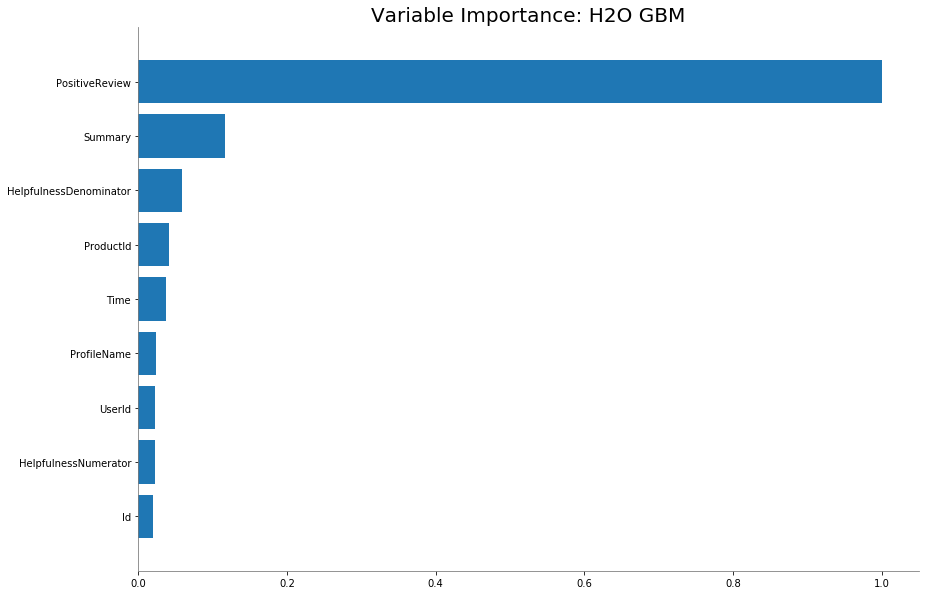

In [26]:
model.varimp_plot()

## Feature selection--Prabhu

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

In machine learning and statistics, feature selection, also known as variable selection, attribute selection or variable subset selection, is the process of selecting a subset of relevant features for use in model construction.

In [27]:
# We convert a AutoML leaderboard into a dataframe
aml_leaderboard_df=aml.leaderboard.as_data_frame()

We define 2 functions over here to help us further:
    
* `get_model_by_algo` - used to find the model if present by searching through the leaderboard and fetch the first best out of it

* `feature_selection` - used to select the feature above a particular threshold. Which will be explained further.

In [28]:
def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)
            return mod,mod_id
    return mod,mod_id 

def feature_selection(d,l, thresh=0.05):
    iv=[]
    for key in d.keys():
      if d[key]>thresh:
        iv.append(key)
    for v in iv:
        if v not in l:
            iv.remove(v)
    return iv

In [29]:
models_dict={}
for m in aml_leaderboard_df['model_id']:
    print(m)
    models_dict[m]=None 
    
    
print(models_dict)    
    
varimp={}    
    
# To search for the first best DRF model in the leaderboard    
mod,mod_id=get_model_by_algo("DRF",models_dict)

if mod is not None:
    l=mod.varimp()
    for v in l:
        varimp[v[0]]=v[2]
    
# To search for the first best XRT model in the leaderboard    
mod,mod_id=get_model_by_algo("XRT",models_dict)
if mod is not None:    
    l=mod.varimp()
    for v in l:
        if v[0] in varimp:   
            varimp[v[0]]=((v[2]+varimp[v[0]])/2)
        else:   
            varimp[v[0]]=((v[2]+0.0)/3) 
        
# To search for the first best GBM model in the leaderboard    
mod,mod_id=get_model_by_algo("GBM",models_dict)
if mod is not None:    
    l=mod.varimp()
    for v in l:
        if v[0] in varimp:   
            varimp[v[0]]=((v[2]+varimp[v[0]])/2)
        else:   
            varimp[v[0]]=((v[2]+0.0)/3)         

print(varimp)          
print(X)
X_Orig=X
X=feature_selection(varimp,X)


StackedEnsemble_AllModels_AutoML_20190316_014627
StackedEnsemble_BestOfFamily_AutoML_20190316_014627
GBM_1_AutoML_20190316_014627
GBM_5_AutoML_20190316_014627
GBM_2_AutoML_20190316_014627
GBM_3_AutoML_20190316_014627
XGBoost_1_AutoML_20190316_014627
GBM_4_AutoML_20190316_014627
XGBoost_2_AutoML_20190316_014627
XGBoost_3_AutoML_20190316_014627
XRT_1_AutoML_20190316_014627
DRF_1_AutoML_20190316_014627
GLM_grid_1_AutoML_20190316_014627_model_1
{'StackedEnsemble_AllModels_AutoML_20190316_014627': None, 'StackedEnsemble_BestOfFamily_AutoML_20190316_014627': None, 'GBM_1_AutoML_20190316_014627': None, 'GBM_5_AutoML_20190316_014627': None, 'GBM_2_AutoML_20190316_014627': None, 'GBM_3_AutoML_20190316_014627': None, 'XGBoost_1_AutoML_20190316_014627': None, 'GBM_4_AutoML_20190316_014627': None, 'XGBoost_2_AutoML_20190316_014627': None, 'XGBoost_3_AutoML_20190316_014627': None, 'XRT_1_AutoML_20190316_014627': None, 'DRF_1_AutoML_20190316_014627': None, 'GLM_grid_1_AutoML_20190316_014627_model_1'

Below are original and the nest list of features

In [30]:
print(X_Orig)
print(len(X_Orig))
print(X)
print(len(X))

['HelpfulnessDenominator', 'Id', 'HelpfulnessNumerator', 'Time', 'ProductId', 'UserId', 'Summary', 'ProfileName', 'PositiveReview', 'Text']
10
['PositiveReview', 'Summary', 'HelpfulnessDenominator', 'ProductId']
4


We train the model by just taking the new list of features which is reduced by ignoring few unimportant features based on the standard coefficient

In [31]:
aml.train(x=X,y=y,training_frame=review_train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [32]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190316_014627,0.422273,0.649826,0.422273,0.355163,0.199634
StackedEnsemble_BestOfFamily_AutoML_20190316_014627,0.427416,0.653771,0.427416,0.354096,0.20085
GBM_1_AutoML_20190316_014627,0.430371,0.656027,0.430371,0.353818,0.20179
GBM_5_AutoML_20190316_014627,0.433178,0.658163,0.433178,0.371537,0.202767
GBM_2_AutoML_20190316_014627,0.436619,0.660771,0.436619,0.357969,0.203025
GBM_3_AutoML_20190316_014627,0.439993,0.66332,0.439993,0.374597,0.20415
GBM_1_AutoML_20190316_015451,0.447394,0.668876,0.447394,0.357265,0.206253
XGBoost_1_AutoML_20190316_014627,0.450477,0.671176,0.450477,0.358079,0.206316
GBM_4_AutoML_20190316_014627,0.451152,0.671679,0.451152,0.376072,0.206668
GBM_3_AutoML_20190316_015451,0.453093,0.673121,0.453093,0.36321,0.207432


## Summary of feature selection

So, as we observe, by removing the unimportant features, doesn't make much of a different, rather NO difference at all to the model. So, this is a win for us, as this can help us use less computing power for our dataset by removing insignificant figuers from the whole bunch of them, and improving our model selection.
This is called Feature Selection.

# Building Classification model

## Algorithms(GBM)--Grace

We have created categorical column to perform our regression for ease.

In [33]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [34]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [35]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                            stopping_rounds = 5, score_tree_interval = 10,
                                            model_id = "gbm_baseline.hex"
                                           )
gbm_baseline.train(x = predictors, y = response, 
                   training_frame = train, validation_frame = test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
print("AUC on Validation Data: " + str(round(gbm_baseline.auc(valid = True), 3)))

AUC on Validation Data: 0.595


In [37]:
gbm_baseline.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48181784133938027: 


,0,1,Error,Rate
0,640.0,3572.0,0.8481,(3572.0/4212.0)
1,237.0,6703.0,0.0341,(237.0/6940.0)
Total,877.0,10275.0,0.3416,(3809.0/11152.0)


We can see that there is a big room for improvement.  Our error is large.  To improve our model, we will train word embeddings for the review.

## Model analysis and interpretation--Ziwei

The variable importance plot below shows us that the most important variable is `HelpfulnessNumerator`.  Looking at the partial dependency plot for that variable, we see that the more people who find the review helpful, the more likely it is a good review.

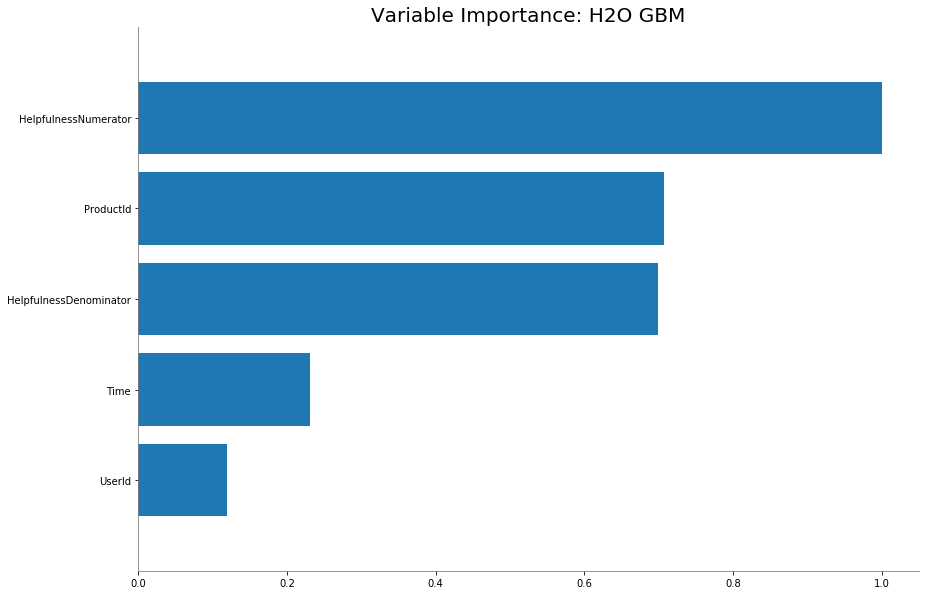

In [38]:
gbm_baseline.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


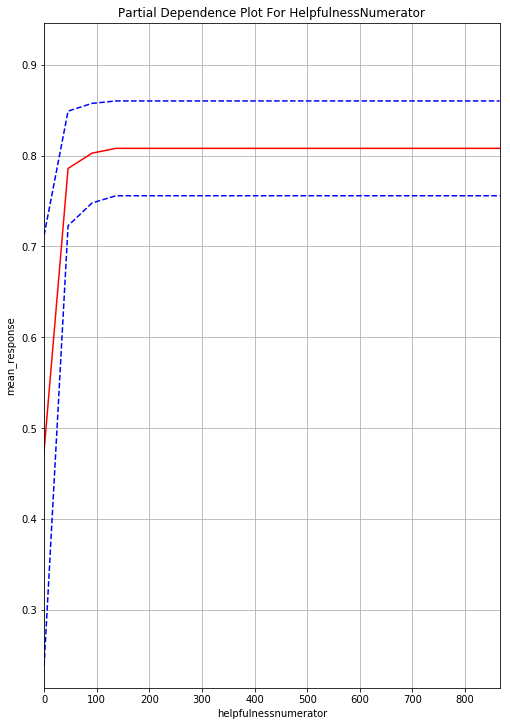

In [39]:
%matplotlib inline  
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ["HelpfulnessNumerator"])

## Feature Extraction--Maha

### Tokenize Words in Review

Our first step will be to tokenize the words in the review column. We will do this by creating a function called `tokenize`.  This will split the reviews into words and remove any stop words, small words, or words with numbers in them.

In [40]:
data_path = "data/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [41]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [42]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [43]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


### Train Word2Vec Model

Now that we've tokenized our words, we can train a word2vec model.  We can use the `find_synonms` function to sanity check our word2vec model after training.


Word2Vec https://youtu.be/xMwx2A_o5r4 


In [44]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator


w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)

'''
'''
# Pre-trained model built with commented out code
# w2v_model = h2o.load_model('data/w2v.hex')

In [45]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.7926084995269775),
             ('coffees', 0.7841256856918335),
             ('java', 0.765233039855957),
             ('starbucks', 0.7604166865348816),
             ('espresso', 0.7589645981788635)])

In [46]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('unedible', 0.656590461730957),
             ('rancid', 0.6289927363395691),
             ('tastless', 0.6259819269180298),
             ('expired', 0.620013952255249),
             ('tasteless', 0.6100489497184753)])

Now that we have a word embedding for each word in our vocabulary, we will aggregate the words for each review using the `transform` function.  This will give us one aggregated word embedding for each review.

In [47]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

In [48]:
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.062347,-0.0588258,-0.0835967,-0.00559373,0.0428912,-0.0267936,0.104931,0.00967785,-0.0529858,0.0221866,-0.0290056,0.227888,0.0922556,-0.0360627,-0.0384852,-0.0666051,0.105657,-0.0100025,-0.160406,-0.0103023,0.00163029,0.131221,0.114855,-0.0459233,0.198304,-0.0337662,0.0374565,0.0502606,0.113678,-0.164801,0.157526,0.097311,0.0691677,-0.0121418,-0.045456,-0.0459862,-0.132748,0.0597048,-0.312681,-0.151295,-0.0823302,-0.0596924,0.194041,-0.0844054,-0.154761,0.0260935,-0.130939,0.0727831,-0.077613,-0.0962459,0.12029,0.011807,-0.0895779,0.0793395,-0.311407,0.035423,-0.11998,0.25417,0.173696,-0.0246004,-0.0366733,0.187235,0.0389387,-0.198011,0.0147267,-0.0968508,0.0283926,-0.0117295,0.0154175,-0.123969,0.0128401,0.0147304,0.000496513,0.0299696,0.103827,0.062661,-0.0745495,0.0750781,-0.0752526,-0.115472,-0.0763027,0.0558412,0.0974219,0.00763419,0.184565,-0.0102613,0.108633,0.0474608,0.0371521,0.0667414,0.0984622,0.106706,-0.0185399,-0.0634558,0.130598,0.080479,0.0179517,-0.217013,0.237813,-0.0111079
-0.0291201,0.03508,0.0743475,0.0975453,-0.156627,-0.0729098,-0.0684344,-0.064415,0.0300497,0.101563,0.0235929,0.191391,0.0924027,0.127659,-0.0637069,-0.0498886,0.260305,0.0562298,-0.0842424,-0.0996491,-0.0710535,0.100052,-0.232848,0.0694554,0.117242,-0.172564,0.0272743,0.102175,0.0944083,-0.188306,0.133227,-0.0652834,0.0345311,-0.069944,-0.0755667,0.128042,-0.166085,0.17398,0.00921495,-0.126404,-0.155631,0.130049,0.0219046,-0.0941863,-0.0948931,0.0626827,-0.246493,0.151052,0.00136315,-0.238074,0.13723,0.0560593,-0.182075,0.135135,-0.106698,0.0176883,0.029718,0.00498645,0.0937753,-0.0307687,0.0249517,0.0538717,0.0894675,-0.0577808,-0.0961138,-0.104694,0.05885,-0.0800442,0.143277,-0.00171285,-0.0111464,0.0510947,-0.0942846,-0.027282,0.161175,0.0322681,-0.111653,0.00676722,0.0507423,0.0794982,-0.0614712,0.0520543,-0.076837,0.111434,0.148585,-0.0579389,-0.133021,0.169889,-0.0127883,0.120348,-0.144453,-0.0184458,0.0855538,-0.0944833,0.172324,-0.0477156,-0.0315344,-0.0947723,0.132675,0.183698
0.20158,0.0757392,-0.1075,0.0274616,-0.0602973,-0.0983174,-0.103327,-0.0406128,-0.0720542,0.140224,-0.0760421,0.0646709,0.0333022,0.103238,-0.047884,-0.0560934,0.134182,-0.0841167,-0.243051,-0.00598843,0.0672796,0.0781987,0.000123294,0.00846471,0.289807,-0.0735025,0.0777899,-0.0640771,0.0138925,-0.114167,-0.00873751,0.0112622,0.0783861,-0.0140924,-0.118953,0.0207363,-0.168171,0.166451,-0.10894,-0.0989548,-0.0343468,-0.0498982,0.171022,-0.0473003,-0.201851,0.0679345,-0.11753,0.21084,-0.112225,-0.134878,0.168106,0.106973,-0.172291,0.0799008,-0.18875,0.111581,-0.196475,0.0500731,0.146754,-0.0266385,0.0141109,0.0727238,0.111566,-0.0547416,-0.133026,-0.158616,-0.0329496,-0.0735852,0.0586285,-0.131054,-0.0453415,-0.0569075,0.106008,0.0174936,0.0814462,-0.00919243,-0.0944906,-0.0454448,-0.0433555,-0.0108229,-0.187281,0.0240431,-0.0381509,0.0116868,0.0725238,-0.0629517,0.182982,0.0428117,0.0249535,-0.0316951,0.0353554,0.0507892,0.0149563,-0.0553076,0.0404572,0.0863875,-0.012817,-0.156136,0.128299,0.093169
0.15494,-0.058325,-0.0505579,-0.0127078,-0.020053,-0.0544669,0.102969,0.0446047,-0.0656972,0.165941,-0.0870836,0.0595144,0.0049028,0.0384678,0.0323977,-0.0509703,0.214737,0.13022,-0.219269,0.0312443,0.0577133,-0.0506474,0.00608543,0.0537934,0.221017,-0.0737898,-0.0305086,0.00464593,-0.0390277,-0.0808416,0.0560095,0.00605736,0.0590364,-0.0598305,-0.195192,-0.0476939,-0.192066,0.157251,-0.109833,-0.125871,-0.22468,-0.0560023,0.081846,-0.0587174,-0.180034,0.0689271,-0.153752,0.0900661,-0.00811271,-0.113594,0.24367,0.0768665,-0.130382,0.0990646,-0.142108,-0.0343476,-0.0743844,0.026

In [49]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

### Train GBM Model to Predict Good Review

We will train a GBM model with the same parameters as our baseline gbm.  This time, however, we will add the aggregated word embeddings as predictors. 

In [50]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [51]:
predictors = predictors + review_vecs.names
response = 'PositiveReview'

gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [52]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))

Baseline AUC: 0.595
With Embeddings AUC: 0.812


In [53]:
gbm_embeddings.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46235023372076506: 


,0,1,Error,Rate
0,2114.0,2098.0,0.4981,(2098.0/4212.0)
1,615.0,6325.0,0.0886,(615.0/6940.0)
Total,2729.0,8423.0,0.2433,(2713.0/11152.0)


## Summary of feature extraction

The gbm_embeddings model has a better AUC then the gbm_baseline model. Thus, feature extraction helps in making the model predict much better.

# Predict on New Reviews--Grace

Now that we've built a model we are satisifed with, we will see how the model performs on new reviews.

* *"The taste is great! especially when you cook it with some vegetable and egg. I like it very much, though it's more expensive than the other noodles"*


* *"Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."*

In [54]:
def predict(reviews, w2v, gbm):
    
    words = tokenize(reviews["Text"].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method="AVERAGE")
    
    summary_words = tokenize(reviews["Summary"].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method="AVERAGE")
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))

In [55]:
good_review = h2o.H2OFrame([["B000EQT574", "AISQLBDGS2KXR", 1, 1, 1263340800, 
                             "Delicious",
                             "These chips are delicious. Salty sweet with a hint of spice. I have no idea how Tamari is supposed to taste, but these chips are awesome. I just finished an entire bag in one day!"]])

good_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [56]:
bad_review = h2o.H2OFrame([["B003BJZMSM", "A2JBZHQVQF7MV0", 1, 2, 1274832000, 
                            "Pretty tasteless",
                            "Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."]])

bad_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


**gbm_embeddings**

```python
gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )
```

**w2v_model**


```python
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)
```

**predict**

```python
def predict(reviews, w2v, gbm):
    
    words = tokenize(reviews["Text"].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method="AVERAGE")
    
    summary_words = tokenize(reviews["Summary"].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method="AVERAGE")
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))

```

In [57]:
# Predict!
print("Good Review: ")
print(predict(good_review, w2v_model,gbm_embeddings))

print("Bad Review: ")
print(predict(bad_review, w2v_model, gbm_embeddings))

Good Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.28813,0.71187



None
Bad Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.899781,0.100219



None


In [59]:
h2o.cluster().shutdown()

# <center>Thank You</center>

<center><img src="./Images/thankyou.jpg" width="280"></center>

### <center>NEU AI Skunkworks</center>

## <center>Contact</center>

<center><img src="./Images/banner.png" width="800"></center>
<center><font size='4'>GitHub : <a href=https://github.com/skunkworksneu>https://github.com/skunkworksneu</a></center>
<center><font size='4'>Email ID: <a href=skunkworksneu@gmail.com>skunkworksneu@gmail.com</a></center>
<center><font size='4'>LinkedIn : <a href=http://linkedin.com/company/skunkworksneu>http://linkedin.com/company/skunkworksneu</a></center>    